# Final Project: Egg Flipping Robot

In [1]:
# others
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from IPython.display import HTML

# drake
from pydrake.all import (
    AddMultibodyPlantSceneGraph, MultibodyPlant, Parser, DiagramBuilder, Simulator,
    PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource, SnoptSolver,
    MultibodyPositionToGeometryPose, PiecewisePolynomial, MathematicalProgram,
    JacobianWrtVariable, eq, FittedValueIteration, DynamicProgrammingOptions,
    LeafSystem, FiniteHorizonLinearQuadraticRegulator,
    MakeFiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions, PidController
)

## Setup

### Parameters and URDF

In [2]:
# friction coefficient between egg and spatula
g = 9.81
friction = .3

# parameters
spatula_width    = .150
spatula_height   = .01
spatula_mass     = .24307
spatula_Ixx      = .00045778
spatula_Iyy      = .00034435
spatula_Izz      = .00079807

# calculated using a very precise Solidworks model
egg_white_width  = .125
egg_white_height = .010
egg_yolk_width   = .050
egg_yolk_height  = .020
egg_com_height   = .00699
egg_mass         = .15051
egg_Ixx          = .00013065
egg_Iyy          = .00013065
egg_Izz          = .00025190

E1 = np.array([-egg_white_width/2, 0, -egg_com_height])
E2 = np.array([ egg_white_width/2, 0, -egg_com_height])

egg_flipper_urdf = f"""<?xml version="1.0"?>
<robot name="EggFlipper">
    <link name="spx">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0" />
        </inertial>
    </link>
    <link name="spz">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0" />
        </inertial>
    </link>
    <link name="spatula">
        <visual>
            <origin xyz="0 0 {-spatula_height/2}" />
            <geometry>
                <box size="{spatula_width} .1 {spatula_height}" />
            </geometry>
            <material>
                <color rgba="0.3 0.3 0.3 1" />
            </material>
        </visual>

        <collision>
            <origin xyz="0 0 {-spatula_height/2}" />
            <geometry>
                <box size="{spatula_width} .1 {spatula_height}" />
            </geometry>
            <contact_coefficients mu="{friction}" />
        </collision>

        <inertial>
            <origin xyz="0 0 0" />
            <mass value="{spatula_mass}" />
            <inertia ixx="{spatula_Ixx}" ixy="0" ixz="0" iyy="{spatula_Iyy}" iyz="0" izz="{spatula_Izz}" />
        </inertial>
    </link>


    <joint name="sp_x" type="prismatic">
        <parent link="world" />
        <child link="spx" />
        <axis xyz="1 0 0" />
    </joint>
    <transmission type="SimpleTransmission" name="x_force">
        <actuator name="act_x" />
        <joint name="sp_x" />
    </transmission>

    <joint name="sp_z" type="prismatic">
        <parent link="spx" />
        <child link="spz" />
        <axis xyz="0 0 1" />
    </joint>
    <transmission type="SimpleTransmission" name="z_force">
        <actuator name="act_z" />
        <joint name="sp_z" />
    </transmission>

    <joint name="sp_theta" type="continuous">
        <parent link="spz" />
        <child link="spatula" />
        <axis xyz="0 -1 0" />
        <origin xyz="0 0 0" />
    </joint>
    <transmission type="SimpleTransmission" name="th_force">
        <actuator name="act_th" />
        <joint name="sp_theta" />
    </transmission>


    <link name="eggx">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0" />
        </inertial>
    </link>
    <link name="eggz">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0" />
        </inertial>
    </link>
    <link name="egg">
        <visual>
            <origin xyz="0 0 {1/2*egg_white_height}" />
            <geometry>
                <box size="{egg_white_width} .1 {egg_white_height}" />
            </geometry>
            <material>
                <color rgba="0.8 0.8 0.8 1" />
            </material>
        </visual>
        <visual>
            <origin xyz="0 0 {egg_white_height + 1/2*egg_yolk_height}" />
            <geometry>
                <box size="{egg_yolk_width} .1 {egg_yolk_height}" />
            </geometry>
            <material>
                <color rgba="0.7 0.7 0.0 1" />
            </material>
        </visual>

        <collision>
            <origin xyz="0 0 {1/2*egg_white_height}" />
            <geometry>
                <box size="{egg_white_width} .1 {egg_white_height}" />
            </geometry>
            <contact_coefficients mu="friction" />
        </collision>
        <collision>
            <origin xyz="0 0 {egg_white_height + 1/2*egg_yolk_height}" />
            <geometry>
                <box size="{egg_yolk_width} .1 {egg_yolk_height}" />
            </geometry>
        </collision>

        <inertial>
            <origin xyz="0 0 {egg_white_height}" />
            <mass value="{egg_mass}" />
            <inertia ixx="{egg_Ixx}" ixy="0" ixz="0" iyy="{egg_Iyy}" iyz="0" izz="{egg_Izz}" />
        </inertial>
    </link>

    <joint name="egg_x" type="prismatic">
        <parent link="world" />
        <child link="eggx" />
        <axis xyz="1 0 0" />
    </joint>
    <joint name="egg_z" type="prismatic">
        <parent link="eggx" />
        <child link="eggz" />
        <axis xyz="0 0 1" />
    </joint>
    <joint name="egg_theta" type="continuous">
        <parent link="eggz" />
        <child link="egg" />
        <axis xyz="0 -1 0" />
        <origin xyz="0 0 0" />
    </joint>
</robot>
"""

## Trajectory Optimization Formulation

### MultibodyPlant Insantiation

In [3]:
# instantiate the egg flipper
egg_flipper = MultibodyPlant(time_step=0)
Parser(egg_flipper).AddModelFromString(egg_flipper_urdf, "urdf")
egg_flipper.Finalize()

# make autodiff copy
egg_flipper_autodiff = egg_flipper.ToAutoDiffXd()

# number of variables of each type
nq = egg_flipper.num_positions()  # configuration variables
nf = 4                            # contact force terms 
nu = 3                            # control inputs

### Helper Functions

In [4]:
# creates a unit vector that points in the direction of the
# angle th
def dir_vec(th):
    return np.array([np.cos(th), 0, -np.sin(th)])

# creates a 3D rotation matrix that represents a rotation of
# th about the y axis
def rot_mat(th):
    return np.array([
        [ np.cos(th), 0, np.sin(th)],
        [          0, 1, 0         ],
        [-np.sin(th), 0, np.cos(th)]
    ])

# Function that given the current configuration, velocities,
# accelerations, contact forces, and control inputs, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):
    # split input vector in subvariables
    assert vars.size == 3 * nq + nf + nu
    split_at = [nq, 2*nq, 3*nq, 3*nq+nf]
    q, qd, qdd, f, u = np.split(vars, split_at)

    egg_flipper_eval = egg_flipper_autodiff # if vars.dtype == object else egg_flipper
    
    # set egg flipper state
    context = egg_flipper_eval.CreateDefaultContext()
    egg_flipper_eval.SetPositions(context, q)
    egg_flipper_eval.SetVelocities(context, qd)

    sS = np.sin(q[2])
    cS = np.cos(q[2])

    # manipulator equations matrices and/or terms
    Mqdd = np.array([spatula_mass*qdd[0], spatula_mass*qdd[1], spatula_Iyy*qdd[2], egg_mass*qdd[3], egg_mass*qdd[4], egg_Iyy*qdd[5]])
    tauG = np.array([0, -g*spatula_mass, 0, 0, -g*egg_mass, 0])
    Bu = np.array([
        u[0],
        u[1],
        u[2] + spatula_height/2*(u[0]*np.cos(q[2])-u[1]*np.sin(q[2])),
        0,0,0
    ])

    # calculate b1 and b2 (i.e. projection of egg corners onto spatula)
    egg_frame = egg_flipper_eval.GetBodyByName('egg').body_frame()
    spatula_frame = egg_flipper_eval.GetBodyByName('spatula').body_frame() 

    egg_cp_positions = egg_flipper_eval.CalcPointsPositions(
        context,
        egg_frame,
        np.array([[-egg_white_width/2,0,0], [egg_white_width/2,0,0]]).T,
        spatula_frame
    )

    b1 = egg_cp_positions[0,0]
    b2 = egg_cp_positions[0,1]

    # calculate contact forces
    R = rot_mat(q[2])
    N_dir = dir_vec(q[2] - np.pi/2)
    f_dir = dir_vec(q[2])

    W = np.array([
        [-sS, -sS, -cS, -cS],
        [-cS, -cS,  sS,  sS],
        [ b1,  b2, -spatula_height/2, -spatula_height/2],
        [ sS,  sS,  cS,  cS],
        [ cS,  cS, -sS, -sS],
        [np.cross(R.dot(E1), N_dir)[0], np.cross(R.dot(E2), N_dir)[0], np.cross(R.dot(E1), f_dir)[0], np.cross(R.dot(E2), f_dir)[0]]
    ], dtype=object)

    return Mqdd - tauG - Bu - W.dot(f)

# calculate locations of the corners of the egg in the
# frame of the spatula
def egg_corners_in_spatula_frame(q):
    egg_flipper_eval = egg_flipper_autodiff # if q.dtype == object else egg_flipper

    context = egg_flipper_eval.CreateDefaultContext()
    egg_flipper_eval.SetPositions(context, q)

    egg_frame     = egg_flipper_eval.GetBodyByName('egg').body_frame()
    spatula_frame = egg_flipper_eval.GetBodyByName('spatula').body_frame() 

    return egg_flipper_eval.CalcPointsPositions(
        context,
        egg_frame,
        np.array([[-egg_white_width/2,0,0], [egg_white_width/2,0,0]]).T,
        spatula_frame
    )

# projection of the egg corner locations onto the
# spatula's surface
def egg_corner_projections(q):
    return egg_corners_in_spatula_frame(q)[0,:]

# projection of the egg corner locations onto the
# spatula's normal vector, i.e. the distance function
def egg_corner_distances(q):
    return egg_corners_in_spatula_frame(q)[2,:]

# product of the distance between the spatula egg corner
# with the normal force. should always be 0 (since an egg
# only has non-zero normal force when it is in contact
# with the spatula)
def normal_times_distance(vars):
    assert vars.size == nq + nf
    split_at = [nq]
    q, f = np.split(vars, split_at)

    dists = egg_corner_distances(q)
    return [f[0] * dists[0], f[1] * dists[1]]

### Optimization Problem

#### Setup and Decision Variables

In [5]:
# number of timesteps in trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .002
#h_max = .02            # GUESS 1
h_max = .05            # GUESS 2

# initialize program
prog = MathematicalProgram()

# ====================
#  DECISION VARIABLES
# ====================

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(T, name='h')

# system configuration, generalized velocities, and accelerations
# q = [xs, zs, ths, xe, ze, the]
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# control inputs (forces and torques on the spatula)
# u = [ux, uz, uth]
u = prog.NewContinuousVariables(rows=T, cols=nu, name='u')

# contact forces (normal & friction)
# f = [N1, N2, f1, f2]
f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

#### Constraints

In [6]:
# lower and upper bound on the time steps for all t
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

for t in range(T):
    # MULTIBODY DYNAMICS
    # link the configurations, velocities, and accelerations
    # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

    # manipulator equations for all t (implicit Euler)
    vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t], u[t]))
    prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars)

    # EGG RULES
    # egg stays in contact/near and above surface of spatula
    prog.AddConstraint(egg_corner_distances, lb=[0]*2, ub=[.001]*2, vars=q[t,:])

    # egg stays above pan
    prog.AddLinearConstraint(q[t, 4] >= 0)

    # CONTACT DYNAMICS
    # normal force >= 0 (i.e. no stickiness)
    prog.AddLinearConstraint(f[t,0] >= 0)
    prog.AddLinearConstraint(f[t,1] >= 0)

    # friction force no greater than max
    prog.AddConstraint(f[t,2]*f[t,2] <= friction*friction*f[t,0]*f[t,0])
    prog.AddConstraint(f[t,3]*f[t,3] <= friction*friction*f[t,1]*f[t,1])

    # normal forces only exists during contact
    q_and_f = np.concatenate((q[t], f[t]))
    prog.AddConstraint(normal_times_distance, lb=[0,0], ub=[0,0], vars=q_and_f)

    # egg stays within horizontal bounds of spatula when in contact
    prog.AddConstraint(egg_corner_projections, lb=[-spatula_width/2]*2, ub=[spatula_width/2]*2, vars=q[t])

# system starting conditions - everything at 0
prog.AddLinearConstraint(eq(q[0], [0]*nq))
prog.AddLinearConstraint(eq(qd[0], [0]*nq))

# egg end pose = upside down with top of yolk touching the pan
prog.AddLinearConstraint(q[-1, 4] == egg_white_height + egg_yolk_height)
prog.AddLinearConstraint(q[-1, 5] == np.pi)
    

<pydrake.solvers.mathematicalprogram.Binding[LinearConstraint] at 0x7fb7928f7630>

#### Costs

In [7]:
for i in range(T):
    # penalize actuation
    prog.AddQuadraticCost(10*u[i].T.dot(u[i]))

    # penalize high velocity
    prog.AddQuadraticCost(qd[i].T.dot(qd[i]))

    # penalize high difference in normal force
    prog.AddQuadraticCost(1000*(f[i,0]-f[i,1])*(f[i,0]-f[i,1]))

    # penalize the egg going super high
    prog.AddLinearCost(100*q[i, 4])

# penalize landing far from origin
prog.AddQuadraticCost(10000*q[-1,3]*q[-1,3])

<pydrake.solvers.mathematicalprogram.Binding[QuadraticCost] at 0x7fb78f1e63b0>

#### Initial Guess

In [8]:
initial_guess = np.ones(prog.num_vars())

h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# # GUESS 1
# q_guess_poly = PiecewisePolynomial.CubicHermite(
#     breaks=[0, 0.5*T*h_guess, T*h_guess],
#     samples=[
#         [0,.2,0],
#         [0,.2,egg_white_height + egg_yolk_height],
#         [0,np.pi/2,np.pi],
#         [0,.2,0],
#         [0,.2,egg_white_height + egg_yolk_height],
#         [0,np.pi/2,np.pi]
#     ],
#     samples_dot=[
#         [0,0,0],
#         [0,1,-1],
#         [0,1,0.25],
#         [0,0,0],
#         [0,1,-1],
#         [0,1,0.25]
#     ]
# )

# GUESS 2
q_guess_poly = PiecewisePolynomial.CubicHermite(
    breaks=[0, 0.5*T*h_guess, T*h_guess],
    samples=[
        [0, .2, .2],
        [0,  0, egg_white_height + egg_yolk_height],
        [0,  0, np.pi],
        [0, .2, .2],
        [0,  0, egg_white_height + egg_yolk_height],
        [0,  0, np.pi]
    ],
    samples_dot=[
        [0,  2, 0],
        [0,  0, -5],
        [0, .1, 0.25],
        [0,  2, 0],
        [0,  0, -5],
        [0, .1, 0.25]
    ]
)

# get velocities and accelerations of guess
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = qd_guess_poly.derivative()

# construct guess matricies
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T+1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T+1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T

# build the initial guess for Snopt
prog.SetDecisionVariableValueInVector(q,   q_guess,   initial_guess)
prog.SetDecisionVariableValueInVector(qd,  qd_guess,  initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

prog.SetDecisionVariableValueInVector(f, np.zeros((f.shape)), initial_guess)
prog.SetDecisionVariableValueInVector(u, np.zeros((u.shape)), initial_guess)

#### Solve

In [9]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? False.


### Results

#### Animate

In [10]:
# # animate guess
# h_opt = [h_guess] * T
# time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
# x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, np.hstack((q_guess, qd_guess)).T)

# extract optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
f_opt = result.GetSolution(f)
u_opt = result.GetSolution(u)

# stack states
x_opt = np.hstack((q_opt, qd_opt))

# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
egg_flipper = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
egg_flipper.RegisterAsSourceForSceneGraph(scene_graph)
Parser(egg_flipper).AddModelFromString(egg_flipper_urdf, "urdf")
egg_flipper.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(egg_flipper, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(egg_flipper.get_source_id()))

# add visualizer
xlim=[-.3,1]
ylim=[-.1,1]
viz = PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False)
visualizer = builder.AddSystem(viz)
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))
diagram = builder.Build()

simulator = Simulator(diagram)

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

#### Graph

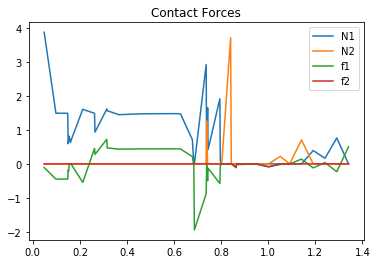

In [11]:
time = np.cumsum(h_opt)

plt.plot(time, f_opt[:,0], label='N1')
plt.plot(time, f_opt[:,1], label='N2')

plt.plot(time, f_opt[:,2], label='f1')
plt.plot(time, f_opt[:,3], label='f2')

plt.title("Contact Forces")
plt.legend()

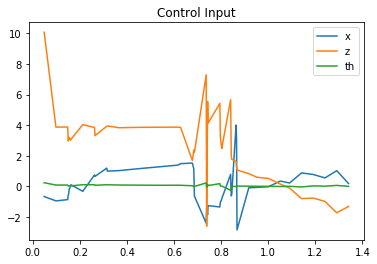

In [12]:
plt.plot(time, u_opt[:,0], label='x')
plt.plot(time, u_opt[:,1], label='z')
plt.plot(time, u_opt[:,2], label='th')
plt.title("Control Input")
plt.legend()


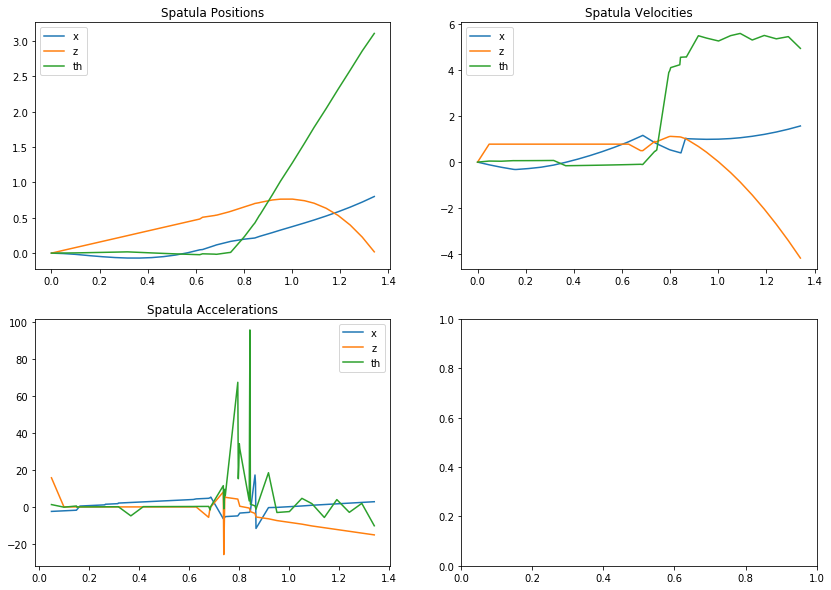

In [13]:
time_0=np.insert(time,0,0)

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(14,10)

axis[0,0].plot(time_0, q_opt[:,0], label='x')
axis[0,0].plot(time_0, q_opt[:,1], label='z')
axis[0,0].plot(time_0, q_opt[:,2], label='th')
axis[0,0].set_title("Spatula Positions")
axis[0,0].legend()

axis[0,1].plot(time_0, qd_opt[:,0], label='x')
axis[0,1].plot(time_0, qd_opt[:,1], label='z')
axis[0,1].plot(time_0, qd_opt[:,2], label='th')
axis[0,1].set_title("Spatula Velocities")
axis[0,1].legend()

axis[1,0].plot(time, qdd_opt[:,0], label='x')
axis[1,0].plot(time, qdd_opt[:,1], label='z')
axis[1,0].plot(time, qdd_opt[:,2], label='th')
axis[1,0].set_title("Spatula Accelerations")
axis[1,0].legend()

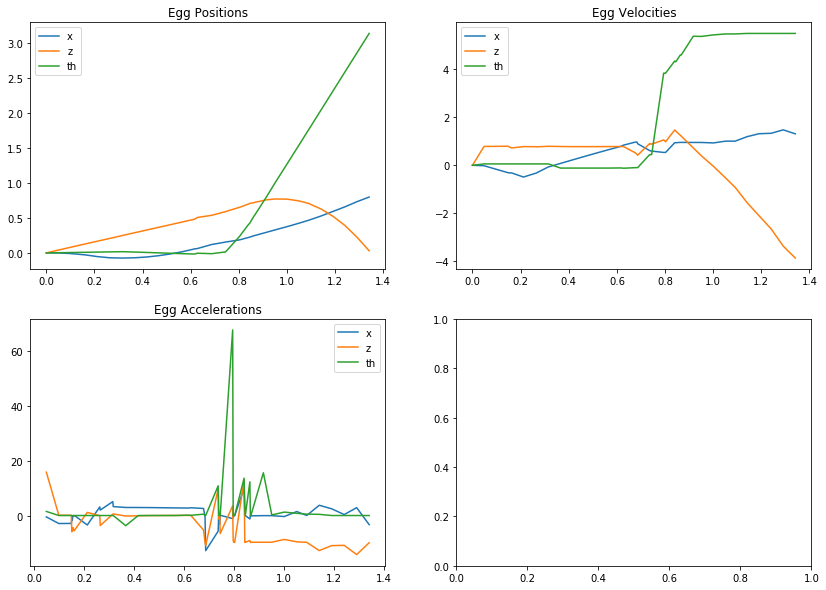

In [14]:
time_0=np.insert(time,0,0)

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(14,10)

axis[0,0].plot(time_0, q_opt[:,3], label='x')
axis[0,0].plot(time_0, q_opt[:,4], label='z')
axis[0,0].plot(time_0, q_opt[:,5], label='th')
axis[0,0].set_title("Egg Positions")
axis[0,0].legend()

axis[0,1].plot(time_0, qd_opt[:,3], label='x')
axis[0,1].plot(time_0, qd_opt[:,4], label='z')
axis[0,1].plot(time_0, qd_opt[:,5], label='th')
axis[0,1].set_title("Egg Velocities")
axis[0,1].legend()

axis[1,0].plot(time, qdd_opt[:,3], label='x')
axis[1,0].plot(time, qdd_opt[:,4], label='z')
axis[1,0].plot(time, qdd_opt[:,5], label='th')
axis[1,0].set_title("Egg Accelerations")
axis[1,0].legend()

### PID Control of Spatula to Achieve Trajectory

In [15]:
# parse urdf with scene graph
egg_flipper = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
egg_flipper.RegisterAsSourceForSceneGraph(scene_graph)
Parser(egg_flipper).AddModelFromString(egg_flipper_urdf, "urdf")
egg_flipper.Finalize()

# make a smaller diagram with just the open-loop system
plant_builder = DiagramBuilder()

egg_flipper, scene_graph = AddMultibodyPlantSceneGraph(plant_builder, time_step=0.0)
Parser(egg_flipper).AddModelFromString(egg_flipper_urdf, "urdf")
egg_flipper.Finalize()

plant_builder.ExportInput(egg_flipper.get_actuation_input_port(), "actuation_input")
plant_builder.ExportOutput(egg_flipper.get_state_output_port(), "state_output")
plant_builder.ExportOutput(scene_graph.get_query_output_port(), "query_output")

plant_diagram = plant_builder.Build()

# add the PID controller
builder = DiagramBuilder()
builder.AddSystem(plant_diagram)

source = builder.AddSystem(TrajectorySource(x_opt_poly))

I3 = np.identity(3)
O3 = np.zeros((3,3))
pid_controller = PidController(
    state_projection = np.diag((1,1,1,0,0,0,1,1,1,0,0,0)),
    output_projection = np.hstack((I3,O3)),
    kp = [70,70,70,0,0,0],
    ki = [0,0,0,0,0,0],
    kd = [10,10,10,0,0,0]
)
builder.AddSystem(pid_controller)

builder.Connect(source.get_output_port(0), pid_controller.get_input_port_desired_state())
builder.Connect(plant_diagram.GetOutputPort("state_output"), pid_controller.get_input_port_estimated_state())
builder.Connect(pid_controller.get_output_port_control(), plant_diagram.GetInputPort("actuation_input"))

# add visualizer
viz = PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False)
visualizer = builder.AddSystem(viz)
builder.Connect(plant_diagram.GetOutputPort("query_output"), visualizer.get_input_port(0))
diagram = builder.Build()

simulator = Simulator(diagram)

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time() + 0.2)
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

### Stabilizing Controller with FHLQR

In [16]:
# interpolate control values for FHLQR
u_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, np.vstack(([0,0,0],u_opt)).T)

small_builder = DiagramBuilder()

egg_flipper, scene_graph = AddMultibodyPlantSceneGraph(small_builder, time_step=0.0)
Parser(egg_flipper).AddModelFromString(egg_flipper_urdf, "urdf")
egg_flipper.Finalize()

small_builder.ExportInput(egg_flipper.get_actuation_input_port(), "actuation_input")
small_builder.ExportOutput(egg_flipper.get_state_output_port(), "state_output")
small_builder.ExportOutput(scene_graph.get_query_output_port(), "query_output")

small_diagram = small_builder.Build()

builder = DiagramBuilder()
builder.AddSystem(small_diagram)

context = small_diagram.CreateDefaultContext()

fhlqr_options = FiniteHorizonLinearQuadraticRegulatorOptions()
fhlqr_options.ud = u_opt_poly
fhlqr_options.u0 = u_opt_poly
fhlqr_options.xd = x_opt_poly
fhlqr_options.x0 = x_opt_poly
fhlqr_options.input_port_index = small_diagram.GetInputPort("actuation_input").get_index()

fhlqr = MakeFiniteHorizonLinearQuadraticRegulator(
    system = small_diagram,
    context = context,
    t0 = time_breaks_opt[0],
    tf = time_breaks_opt[-1],
    Q = np.identity(12),
    R = np.identity(3),
    options = fhlqr_options
)
builder.AddSystem(fhlqr)

builder.Connect(small_diagram.GetOutputPort("state_output"), fhlqr.get_input_port(0))
builder.Connect(fhlqr.get_output_port(0), small_diagram.GetInputPort("actuation_input"))

visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False)
)
builder.Connect(small_diagram.GetOutputPort("query_output"), visualizer.get_input_port(0))

# finish building the block diagram
diagram = builder.Build()

# instantiate a simulator
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

visualizer.start_recording()
    
# reset initial time and state
context = simulator.get_mutable_context()
context.SetTime(0.)
context.SetContinuousState([0]*12)

# run sim
simulator.Initialize()
simulator.AdvanceTo(time_breaks_opt[-1])

# stop video
visualizer.stop_recording()

# construct animation
ani = visualizer.get_recording_as_animation()

# display animation below the cell
display(HTML(ani.to_jshtml()))

# reset to empty video
visualizer.reset_recording()

RuntimeError: Penetration queries between shapes 'Box' and 'Box' are not supported for scalar type drake::AutoDiffXd

## Optimal Control Formulation

### Mesh

In [17]:
# discretization mesh of state space, input space,
# and time for the value-iteration algorithm
mesh = {}

# grid limits
mesh['x_lim']   = [-.2, .4]
mesh['z_lim']   = [-.1, .5]
mesh['th_lim']  = [-1/4 * np.pi, 5/4*np.pi]

mesh['xd_lim']  = [-1., 2.]
mesh['zd_lim']  = [-3., 3.]
mesh['thd_lim'] = [-2., 10.]

mesh['ux_lim']   = [-5., 20.]
mesh['uz_lim']   = [-10., 10.]
mesh['uth_lim']  = [-10., 10.]

# number of knot points in the grids
mesh['n_x']   = 7 # do not exceed ~51/101
mesh['n_z']   = 7
mesh['n_th']  = 7

mesh['n_xd']  = 7 # do not exceed ~51/101
mesh['n_zd']  = 7
mesh['n_thd'] = 7

mesh['n_ux']   = 11  # don't exceed ~11/21
mesh['n_uz']   = 11
mesh['n_uth']  = 11

axes = []
for dim in ['x', 'z', 'th']:
    for suffix in ['', 'd']:
        axes.append(f"{dim}{suffix}")
    axes.append(f'u{dim}')

# axis discretization
# there must be knot points at z=0 and th=pi
for s in axes:
    mesh[f'{s}_grid'] = np.linspace(*mesh[f'{s}_lim'], mesh[f'n_{s}'])
    for i in range(len(mesh[f'{s}_grid'])):
        if abs(mesh[f'{s}_grid'][i]) < 1e-15:
            mesh[f'{s}_grid'][i] = 0

    # important: ensure that a knot point is in the origin
    # otherwise there is no way the value iteration can converge
    assert 0. in mesh[f'{s}_grid'], f"{s}_grid: {mesh[f'{s}_grid']}"
    
# time discretization in the value-iteration algorithm
mesh['timestep'] = 0.005

### System Dynamics

In [18]:
class EggSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        
        self.u_port = self.DeclareVectorInputPort("u", 3)

        state_index = self.DeclareContinuousState(6)
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.lam_port = self.DeclareVectorOutputPort("lam", 3, self._calc_contact_forces)

    def DoCalcTimeDerivatives(self, context, derivatives):
        x_vec = context.get_continuous_state_vector().CopyToVector()
        u = self.u_port.Eval(context)

        x = x_vec[0]
        z = x_vec[1]
        th = x_vec[2]

        xd = x_vec[3]
        zd = x_vec[4]
        thd = x_vec[5]

        ux = u[0]
        uz = u[1]
        uth = u[2]

        xdot = [0]*6
        xdot[0] = xd
        xdot[1] = zd
        xdot[2] = thd

        xdot[3] = ux/(egg_mass + spatula_mass)  
        xdot[4] = -(g*egg_mass - uz + g*spatula_mass)/(egg_mass + spatula_mass) 
        xdot[5] = (2*egg_mass*uth*cos(th)**2 + 2*spatula_mass*uth*cos(th)**2 + 2*egg_mass*uth*sin(th)**2 + 2*spatula_mass*uth*sin(th)**2 - 2*egg_com_height*egg_mass*ux*cos(th) - spatula_height*egg_mass*ux*cos(th) + 2*egg_com_height*egg_mass*uz*sin(th) + spatula_height*egg_mass*uz*sin(th))/(2*(egg_mass + spatula_mass)*(cos(th)**2 + sin(th)**2)*(egg_Iyy + spatula_Iyy))


        for i in range(6):
            derivatives.get_mutable_vector().SetAtIndex(i, xdot[i])

    def _calc_contact_forces(self, context, lam_data):
        lam = lam_data.get_mutable_value()

        x_vec = context.get_continuous_state_vector().CopyToVector()
        u = self.u_port.Eval(context)

        x = x_vec[0]
        z = x_vec[1]
        th = x_vec[2]

        ux = u[0]
        uz = u[1]
        uth = u[2]

        lam[0] = (2*egg_Iyy*egg_mass*uth*cos(th)**2 + 2*egg_Iyy*spatula_mass*uth*cos(th)**2 + 2*egg_Iyy*egg_mass*uth*sin(th)**2 + 2*egg_Iyy*spatula_mass*uth*sin(th)**2 + 2*spatula_Iyy*egg_com_height*egg_mass*ux*cos(th) - egg_Iyy*spatula_height*egg_mass*ux*cos(th) - 2*spatula_Iyy*egg_com_height*egg_mass*uz*sin(th) + egg_Iyy*egg_mass*uz*egg_white_width*cos(th) + spatula_Iyy*egg_mass*uz*egg_white_width*cos(th) + egg_Iyy*spatula_height*egg_mass*uz*sin(th) + egg_Iyy*egg_mass*ux*egg_white_width*sin(th) + spatula_Iyy*egg_mass*ux*egg_white_width*sin(th))/(2*egg_white_width*(egg_mass + spatula_mass)*(cos(th)**2 + sin(th)**2)*(egg_Iyy + spatula_Iyy)) 
        lam[1] = -(2*egg_Iyy*egg_mass*uth*cos(th)**2 + 2*egg_Iyy*spatula_mass*uth*cos(th)**2 + 2*egg_Iyy*egg_mass*uth*sin(th)**2 + 2*egg_Iyy*spatula_mass*uth*sin(th)**2 + 2*spatula_Iyy*egg_com_height*egg_mass*ux*cos(th) - egg_Iyy*spatula_height*egg_mass*ux*cos(th) - 2*spatula_Iyy*egg_com_height*egg_mass*uz*sin(th) - egg_Iyy*egg_mass*uz*egg_white_width*cos(th) - spatula_Iyy*egg_mass*uz*egg_white_width*cos(th) + egg_Iyy*spatula_height*egg_mass*uz*sin(th) - egg_Iyy*egg_mass*ux*egg_white_width*sin(th) - spatula_Iyy*egg_mass*ux*egg_white_width*sin(th))/(2*egg_white_width*(egg_mass + spatula_mass)*(cos(th)**2 + sin(th)**2)*(egg_Iyy + spatula_Iyy))
        lam[2] = (egg_mass*(ux*cos(th) - uz*sin(th)))/((egg_mass + spatula_mass)*(cos(th)**2 + sin(th)**2))


egg_system = EggSystem()

builder = DiagramBuilder()

builder.AddSystem(egg_system)
builder.ExportInput(egg_system.u_port, "u")
builder.ExportOutput(egg_system.lam_port, "lam")

diagram = builder.Build()

simulator = Simulator(diagram)

### Cost Function

In [19]:
def cost_function(context):
    x = context.get_continuous_state_vector().CopyToVector()
    cost = x[1]*x[1] + (x[2] - np.pi)*(x[2] - np.pi)
    
    cf = diagram.GetOutputPort("lam").Eval(context)

    # normal forces must be positive
    if cf[0] < 0: cost += 100000000000000
    if cf[1] < 0: cost += 100000000000000

    # friction cone
    if cf[2]*cf[2] > friction * (cf[0] + cf[1]) * (cf[0] + cf[1]): cost += 100000000000000

    return cost

### Value Iteration

In [20]:
# grids for the value-iteration algorithm
state_grid = [
    set(mesh['x_grid']),
    set(mesh['z_grid']),
    set(mesh['th_grid']),

    set(mesh['xd_grid']),
    set(mesh['zd_grid']),
    set(mesh['thd_grid']),
]
input_grid = [
    set(mesh['ux_grid']),
    set(mesh['uz_grid']),
    set(mesh['uth_grid'])
]

options = DynamicProgrammingOptions()
options.input_port_index = diagram.GetInputPort("u").get_index()

# run value-iteration algorithm 
policy, cost_to_go = FittedValueIteration(
    simulator,
    cost_function,
    state_grid,
    input_grid,
    mesh['timestep'],
    options
)

return policy, cost_to_go

INFO:drake:Computing transition and cost matrices.


KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b1b4563-15c2-4fca-bcd6-c3cf07170d03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>